# Dark Matter Index Analysis: Revised Scientific Investigation

## Background and Original Hypothesis

We originally hypothesized that samples with **high hash density but low alpha diversity** (the "outlier" clusters in hash-diversity space) would have **high Dark Matter Index (DMI)** values — suggesting they contain substantial uncharacterized genetic material that inflates hash counts without contributing to mapped species diversity.

## Critical Finding: The Hypothesis is Refuted

**The data shows the opposite pattern:**
- DMI is *negatively* correlated with hashes_per_mb (ρ ≈ -0.13)
- The outlier clusters (high hashes, low diversity) have predominantly *LOW* DMI
- Only 2/11 major organisms showed significantly elevated DMI in outliers

## Revised Research Questions

1. **What characterizes the outliers?** If not dark matter, what explains high hash density with low diversity?
2. **Where IS the genuine dark matter?** Can we identify samples with true unmapped diversity?
3. **What metadata variables predict outlier membership?**
4. **Is there a better index for identifying dark matter than DMI?**

## Analysis Sections

1. Data Loading and Configuration
2. Decomposing the Hash-Diversity Relationship
3. Proper Outlier Definition and Characterization
4. Metadata Enrichment Analysis (Corrected)
5. Alternative Dark Matter Indices
6. Identifying Genuine Dark Matter Samples
7. Biological Interpretation and Conclusions

In [1]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr, pearsonr, kendalltau, chi2_contingency, fisher_exact, mannwhitneyu
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Data Loading and Configuration

In [2]:
# ============================================================
# CONFIGURATION
# ============================================================

PARQUET_PATH = "/scratch/dmk333_new/Logan/Logan_Analyses/verify_diversity_correlation/data/hash_diversity_results_full_cov_0.0/analysis/filtered_analysis_min_hash_10000_min_diversity_10/filtered_data_with_dmi_merged.parquet"

# Platform filter: ['ILLUMINA'] recommended to avoid long-read error artifacts
PLATFORM_FILTER = ['ILLUMINA']
# PLATFORM_FILTER = 'all'

# Outlier definition thresholds (percentiles)
OUTLIER_HASH_PERCENTILE = 75      # High hashes: > 75th percentile
OUTLIER_DIVERSITY_PERCENTILE = 25  # Low diversity: < 25th percentile

print(f"Configuration:")
print(f"  PARQUET_PATH: {PARQUET_PATH}")
print(f"  PLATFORM_FILTER: {PLATFORM_FILTER}")
print(f"  Outlier definition: hashes > {OUTLIER_HASH_PERCENTILE}th pctl AND diversity < {OUTLIER_DIVERSITY_PERCENTILE}th pctl")

Configuration:
  PARQUET_PATH: /scratch/dmk333_new/Logan/Logan_Analyses/verify_diversity_correlation/data/hash_diversity_results_full_cov_0.0/analysis/filtered_analysis_min_hash_10000_min_diversity_10/filtered_data_with_dmi_merged.parquet
  PLATFORM_FILTER: ['ILLUMINA']
  Outlier definition: hashes > 75th pctl AND diversity < 25th pctl


In [3]:
# Load and filter data
print(f"\nLoading data...")
df_raw = pd.read_parquet(PARQUET_PATH)
print(f"Raw dataset: {len(df_raw):,} samples")

# Apply platform filter
if PLATFORM_FILTER == 'all':
    df = df_raw.copy()
else:
    df = df_raw[df_raw['platform'].isin(PLATFORM_FILTER)].copy()
    print(f"After platform filter ({PLATFORM_FILTER}): {len(df):,} samples")

# Filter to samples with DMI
df = df[df['dmi'].notna()].copy()
print(f"Samples with DMI: {len(df):,}")


Loading data...
Raw dataset: 326,031 samples
After platform filter (['ILLUMINA']): 293,378 samples
Samples with DMI: 293,378


In [4]:
# Compute derived metrics
mbases_col = 'mbases_x' if 'mbases_x' in df.columns else 'mbases'

# Per-Mb normalized metrics
df['unmapped_per_mb'] = df['unmapped_hashes'] / df[mbases_col]
df['mapped_per_mb'] = df['mapped_hashes'] / df[mbases_col]

# Alternative dark matter indices
# Hash Efficiency Ratio: How much diversity do we get per hash?
df['hash_efficiency'] = df['diversity_per_mb'] / df['hashes_per_mb']

# Dark Matter Density: Unmapped hashes per Mb (absolute, not proportion)
# This is different from DMI which is a proportion
df['dark_matter_density'] = df['unmapped_per_mb']

# Mapped Hash Efficiency: Species per mapped hash (× 1M for readability)
df['mapped_efficiency'] = (df['alpha_diversity'] / df['mapped_hashes']) * 1e6

print("Derived metrics computed:")
print("  - unmapped_per_mb: Unmapped hashes per megabase")
print("  - mapped_per_mb: Mapped hashes per megabase")
print("  - hash_efficiency: diversity_per_mb / hashes_per_mb")
print("  - dark_matter_density: Same as unmapped_per_mb")
print("  - mapped_efficiency: Species per million mapped hashes")

Derived metrics computed:
  - unmapped_per_mb: Unmapped hashes per megabase
  - mapped_per_mb: Mapped hashes per megabase
  - hash_efficiency: diversity_per_mb / hashes_per_mb
  - dark_matter_density: Same as unmapped_per_mb
  - mapped_efficiency: Species per million mapped hashes


## 2. Decomposing the Hash-Diversity Relationship

To understand why outliers have LOW DMI (contrary to hypothesis), we need to decompose the total hashes into mapped and unmapped components.

**Key insight**: `hashes_per_mb = mapped_per_mb + unmapped_per_mb`

If outliers have high `hashes_per_mb` but low DMI, then `mapped_per_mb` must be high.

In [5]:
# Correlation analysis: What drives hash density?
print("="*80)
print("DECOMPOSITION ANALYSIS: What drives high hash density?")
print("="*80)

print("\nCorrelations with hashes_per_mb:")
print("-"*50)
for var in ['mapped_per_mb', 'unmapped_per_mb', 'dmi', 'diversity_per_mb', 'alpha_diversity']:
    r, p = spearmanr(df['hashes_per_mb'], df[var])
    print(f"  {var:25} ρ = {r:+.4f}  (p = {p:.2e})")

print("\nCorrelations with diversity_per_mb:")
print("-"*50)
for var in ['mapped_per_mb', 'unmapped_per_mb', 'dmi', 'hashes_per_mb', 'alpha_diversity']:
    r, p = spearmanr(df['diversity_per_mb'], df[var])
    print(f"  {var:25} ρ = {r:+.4f}  (p = {p:.2e})")

DECOMPOSITION ANALYSIS: What drives high hash density?

Correlations with hashes_per_mb:
--------------------------------------------------
  mapped_per_mb             ρ = +0.7693  (p = 0.00e+00)
  unmapped_per_mb           ρ = +0.3726  (p = 0.00e+00)
  dmi                       ρ = -0.0780  (p = 0.00e+00)
  diversity_per_mb          ρ = +0.6793  (p = 0.00e+00)
  alpha_diversity           ρ = +0.2401  (p = 0.00e+00)

Correlations with diversity_per_mb:
--------------------------------------------------
  mapped_per_mb             ρ = +0.6356  (p = 0.00e+00)
  unmapped_per_mb           ρ = +0.2043  (p = 0.00e+00)
  dmi                       ρ = -0.1697  (p = 0.00e+00)
  hashes_per_mb             ρ = +0.6793  (p = 0.00e+00)
  alpha_diversity           ρ = +0.2392  (p = 0.00e+00)


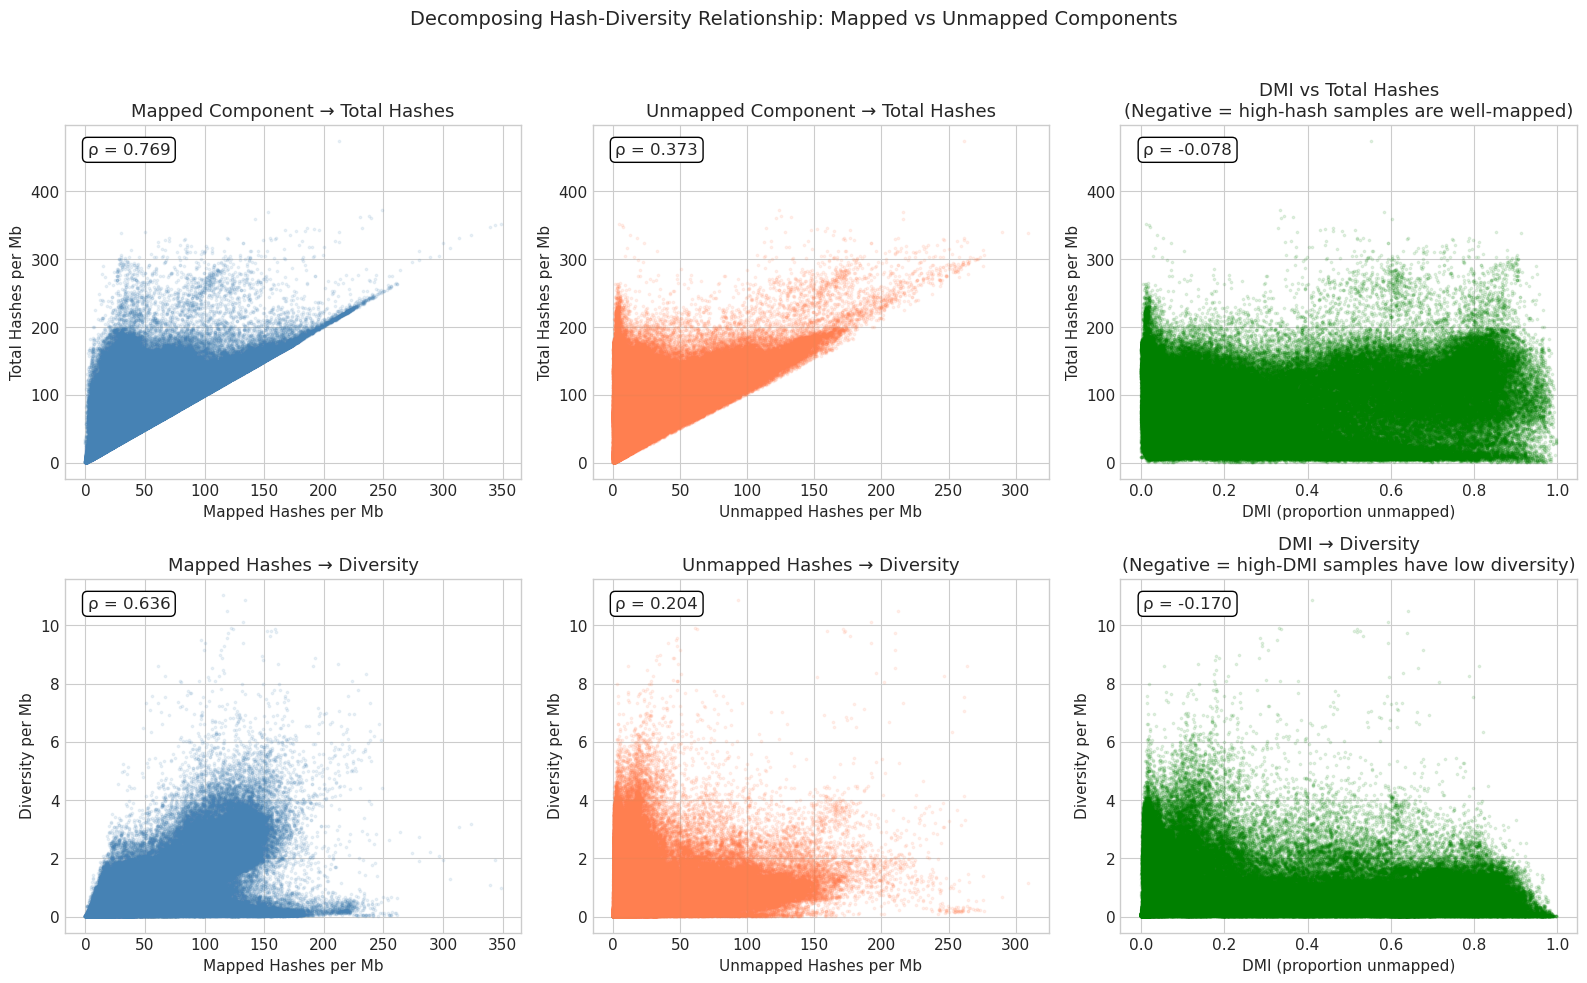

Figure saved: hash_decomposition_analysis.png


In [6]:
# Key insight visualization: Mapped vs Unmapped contribution to total hashes
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Row 1: Components of hashes_per_mb
ax = axes[0, 0]
ax.scatter(df['mapped_per_mb'], df['hashes_per_mb'], alpha=0.1, s=3, c='steelblue')
r, _ = spearmanr(df['mapped_per_mb'], df['hashes_per_mb'])
ax.text(0.05, 0.95, f'ρ = {r:.3f}', transform=ax.transAxes, fontsize=12, va='top',
        bbox=dict(boxstyle='round', facecolor='white'))
ax.set_xlabel('Mapped Hashes per Mb')
ax.set_ylabel('Total Hashes per Mb')
ax.set_title('Mapped Component → Total Hashes')

ax = axes[0, 1]
ax.scatter(df['unmapped_per_mb'], df['hashes_per_mb'], alpha=0.1, s=3, c='coral')
r, _ = spearmanr(df['unmapped_per_mb'], df['hashes_per_mb'])
ax.text(0.05, 0.95, f'ρ = {r:.3f}', transform=ax.transAxes, fontsize=12, va='top',
        bbox=dict(boxstyle='round', facecolor='white'))
ax.set_xlabel('Unmapped Hashes per Mb')
ax.set_ylabel('Total Hashes per Mb')
ax.set_title('Unmapped Component → Total Hashes')

ax = axes[0, 2]
# Proportion of mapped vs unmapped
ax.scatter(df['dmi'], df['hashes_per_mb'], alpha=0.1, s=3, c='green')
r, _ = spearmanr(df['dmi'], df['hashes_per_mb'])
ax.text(0.05, 0.95, f'ρ = {r:.3f}', transform=ax.transAxes, fontsize=12, va='top',
        bbox=dict(boxstyle='round', facecolor='white'))
ax.set_xlabel('DMI (proportion unmapped)')
ax.set_ylabel('Total Hashes per Mb')
ax.set_title('DMI vs Total Hashes\n(Negative = high-hash samples are well-mapped)')

# Row 2: What predicts diversity?
ax = axes[1, 0]
ax.scatter(df['mapped_per_mb'], df['diversity_per_mb'], alpha=0.1, s=3, c='steelblue')
r, _ = spearmanr(df['mapped_per_mb'], df['diversity_per_mb'])
ax.text(0.05, 0.95, f'ρ = {r:.3f}', transform=ax.transAxes, fontsize=12, va='top',
        bbox=dict(boxstyle='round', facecolor='white'))
ax.set_xlabel('Mapped Hashes per Mb')
ax.set_ylabel('Diversity per Mb')
ax.set_title('Mapped Hashes → Diversity')

ax = axes[1, 1]
ax.scatter(df['unmapped_per_mb'], df['diversity_per_mb'], alpha=0.1, s=3, c='coral')
r, _ = spearmanr(df['unmapped_per_mb'], df['diversity_per_mb'])
ax.text(0.05, 0.95, f'ρ = {r:.3f}', transform=ax.transAxes, fontsize=12, va='top',
        bbox=dict(boxstyle='round', facecolor='white'))
ax.set_xlabel('Unmapped Hashes per Mb')
ax.set_ylabel('Diversity per Mb')
ax.set_title('Unmapped Hashes → Diversity')

ax = axes[1, 2]
ax.scatter(df['dmi'], df['diversity_per_mb'], alpha=0.1, s=3, c='green')
r, _ = spearmanr(df['dmi'], df['diversity_per_mb'])
ax.text(0.05, 0.95, f'ρ = {r:.3f}', transform=ax.transAxes, fontsize=12, va='top',
        bbox=dict(boxstyle='round', facecolor='white'))
ax.set_xlabel('DMI (proportion unmapped)')
ax.set_ylabel('Diversity per Mb')
ax.set_title('DMI → Diversity\n(Negative = high-DMI samples have low diversity)')

plt.suptitle('Decomposing Hash-Diversity Relationship: Mapped vs Unmapped Components', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('hash_decomposition_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: hash_decomposition_analysis.png")

In [7]:
# Key insight: What fraction of hashes are mapped vs unmapped?
print("\n" + "="*80)
print("KEY INSIGHT: Contribution of Mapped vs Unmapped to Total Hashes")
print("="*80)

print(f"\nMean contribution to hashes_per_mb:")
print(f"  mapped_per_mb:   {df['mapped_per_mb'].mean():.2f} ({100*df['mapped_per_mb'].mean()/df['hashes_per_mb'].mean():.1f}%)")
print(f"  unmapped_per_mb: {df['unmapped_per_mb'].mean():.2f} ({100*df['unmapped_per_mb'].mean()/df['hashes_per_mb'].mean():.1f}%)")
print(f"  total:           {df['hashes_per_mb'].mean():.2f}")

print(f"\nMedian contribution:")
print(f"  mapped_per_mb:   {df['mapped_per_mb'].median():.2f}")
print(f"  unmapped_per_mb: {df['unmapped_per_mb'].median():.2f}")
print(f"  total:           {df['hashes_per_mb'].median():.2f}")

print(f"\nThis means on average, {100*(1-df['dmi'].mean()):.1f}% of hashes are MAPPED (known sequences).")
print(f"High-hash samples tend to have even MORE mapped content (negative DMI correlation).")


KEY INSIGHT: Contribution of Mapped vs Unmapped to Total Hashes

Mean contribution to hashes_per_mb:
  mapped_per_mb:   56.14 (73.9%)
  unmapped_per_mb: 19.82 (26.1%)
  total:           75.96

Median contribution:
  mapped_per_mb:   47.79
  unmapped_per_mb: 5.63
  total:           69.01

This means on average, 75.6% of hashes are MAPPED (known sequences).
High-hash samples tend to have even MORE mapped content (negative DMI correlation).


## 3. Proper Outlier Definition and Characterization

We define **outliers** as samples with:
- **High hash density**: hashes_per_mb > 75th percentile
- **Low diversity density**: diversity_per_mb < 25th percentile

This captures the "bottom-right" cluster in the hash-diversity scatter plots.

In [8]:
# Define outliers using percentile thresholds
hash_threshold = df['hashes_per_mb'].quantile(OUTLIER_HASH_PERCENTILE / 100)
diversity_threshold = df['diversity_per_mb'].quantile(OUTLIER_DIVERSITY_PERCENTILE / 100)

# Create outlier flag
df['is_outlier'] = (df['hashes_per_mb'] > hash_threshold) & (df['diversity_per_mb'] < diversity_threshold)

n_outliers = df['is_outlier'].sum()
n_normal = (~df['is_outlier']).sum()

print("="*80)
print("OUTLIER DEFINITION")
print("="*80)
print(f"\nCriteria:")
print(f"  High hashes:   hashes_per_mb > {hash_threshold:.2f} (>{OUTLIER_HASH_PERCENTILE}th percentile)")
print(f"  Low diversity: diversity_per_mb < {diversity_threshold:.4f} (<{OUTLIER_DIVERSITY_PERCENTILE}th percentile)")
print(f"\nResults:")
print(f"  Outliers: {n_outliers:,} ({100*n_outliers/len(df):.2f}%)")
print(f"  Normal:   {n_normal:,} ({100*n_normal/len(df):.2f}%)")

OUTLIER DEFINITION

Criteria:
  High hashes:   hashes_per_mb > 108.82 (>75th percentile)
  Low diversity: diversity_per_mb < 0.2526 (<25th percentile)

Results:
  Outliers: 9,256 (3.15%)
  Normal:   284,122 (96.85%)


In [9]:
# Compare outliers vs normal samples
print("\n" + "="*80)
print("OUTLIER vs NORMAL: Key Metrics Comparison")
print("="*80)

comparison_vars = ['hashes_per_mb', 'diversity_per_mb', 'alpha_diversity', 'dmi',
                   'mapped_per_mb', 'unmapped_per_mb', 'hash_efficiency', 'mapped_efficiency']

print("\n{:<25} {:>12} {:>12} {:>12} {:>12}".format(
    'Variable', 'Outlier Med', 'Normal Med', '% Diff', 'Direction'))
print("-"*75)

outlier_comparison = []
for var in comparison_vars:
    outlier_med = df[df['is_outlier']][var].median()
    normal_med = df[~df['is_outlier']][var].median()
    pct_diff = 100 * (outlier_med - normal_med) / normal_med if normal_med != 0 else np.nan
    direction = "HIGHER" if outlier_med > normal_med else "LOWER"
    
    # Statistical test
    stat, pval = mannwhitneyu(df[df['is_outlier']][var], df[~df['is_outlier']][var], alternative='two-sided')
    
    outlier_comparison.append({
        'variable': var,
        'outlier_median': outlier_med,
        'normal_median': normal_med,
        'pct_diff': pct_diff,
        'direction': direction,
        'pvalue': pval
    })
    
    sig = '***' if pval < 0.001 else ('**' if pval < 0.01 else ('*' if pval < 0.05 else ''))
    print(f"{var:<25} {outlier_med:>12.4f} {normal_med:>12.4f} {pct_diff:>+11.1f}% {direction:<8} {sig}")

outlier_comparison_df = pd.DataFrame(outlier_comparison)


OUTLIER vs NORMAL: Key Metrics Comparison

Variable                   Outlier Med   Normal Med       % Diff    Direction
---------------------------------------------------------------------------
hashes_per_mb                 143.7799      66.8302      +115.1% HIGHER   ***
diversity_per_mb                0.1046       0.5425       -80.7% LOWER    ***
alpha_diversity               356.0000    1512.0000       -76.5% LOWER    ***
dmi                             0.0153       0.1298       -88.2% LOWER    ***
mapped_per_mb                 138.3206      46.4903      +197.5% HIGHER   ***
unmapped_per_mb                 2.2829       5.7661       -60.4% LOWER    ***
hash_efficiency                 0.0007       0.0094       -92.5% LOWER    ***
mapped_efficiency             811.4952   12619.2120       -93.6% LOWER    ***


In [10]:
# Critical finding: Outliers have LOWER DMI and HIGHER mapped_per_mb
print("\n" + "="*80)
print("CRITICAL INTERPRETATION")
print("="*80)
print("""
The outliers (high hashes, low diversity) have:

  ✓ LOWER DMI (less dark matter, not more!)
  ✓ HIGHER mapped_per_mb (more known sequences)
  ✓ LOWER unmapped_per_mb (less unknown sequences)
  ✓ LOWER hash_efficiency (fewer species per hash)
  ✓ LOWER mapped_efficiency (fewer species per mapped hash)

This means outliers are NOT dark matter samples.
They are samples DOMINATED BY FEW, WELL-CHARACTERIZED ORGANISMS.

Possible explanations:
  1. Host contamination (e.g., human reads in gut samples)
  2. Bloom samples (few dominant species)
  3. Deep sequencing of low-complexity communities
  4. Samples dominated by organisms with large genomes
""")


CRITICAL INTERPRETATION

The outliers (high hashes, low diversity) have:

  ✓ LOWER DMI (less dark matter, not more!)
  ✓ HIGHER mapped_per_mb (more known sequences)
  ✓ LOWER unmapped_per_mb (less unknown sequences)
  ✓ LOWER hash_efficiency (fewer species per hash)
  ✓ LOWER mapped_efficiency (fewer species per mapped hash)

This means outliers are NOT dark matter samples.
They are samples DOMINATED BY FEW, WELL-CHARACTERIZED ORGANISMS.

Possible explanations:
  1. Host contamination (e.g., human reads in gut samples)
  2. Bloom samples (few dominant species)
  3. Deep sequencing of low-complexity communities
  4. Samples dominated by organisms with large genomes



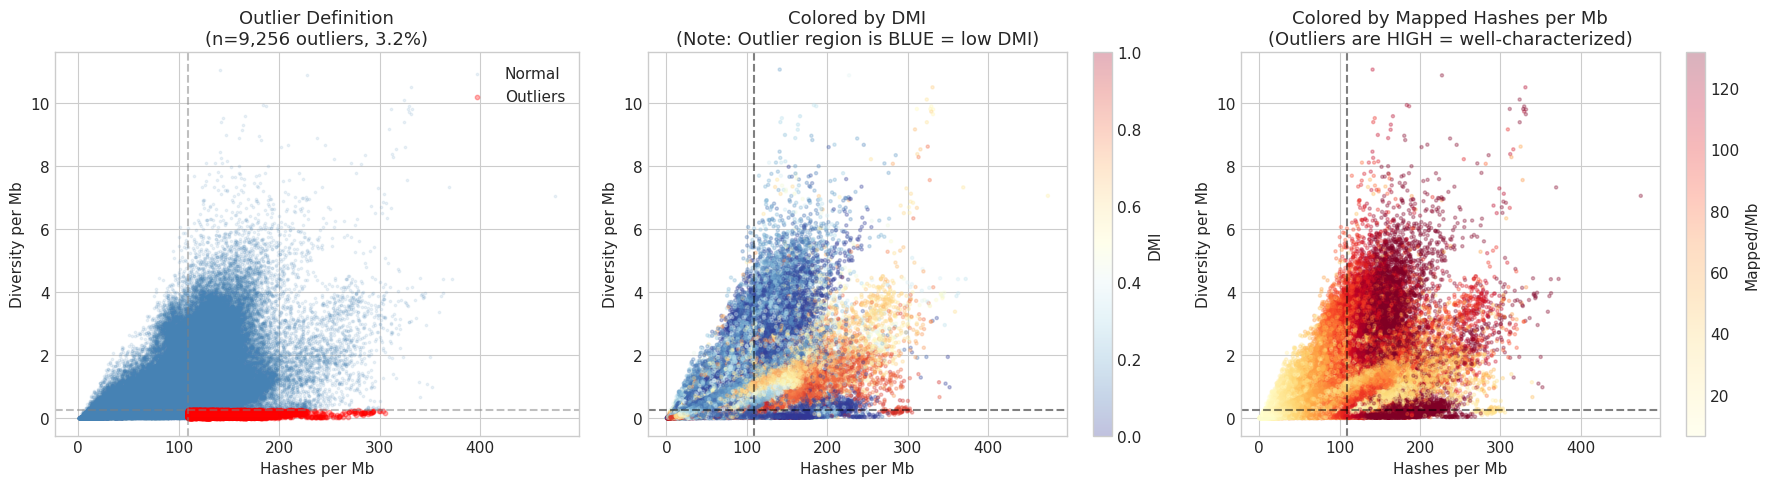

Figure saved: outlier_characterization.png


In [11]:
# Visualize outliers in hash-diversity space
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: Outliers highlighted
ax = axes[0]
normal = df[~df['is_outlier']]
outliers = df[df['is_outlier']]
ax.scatter(normal['hashes_per_mb'], normal['diversity_per_mb'], alpha=0.1, s=3, c='steelblue', label='Normal')
ax.scatter(outliers['hashes_per_mb'], outliers['diversity_per_mb'], alpha=0.3, s=10, c='red', label='Outliers')
ax.axvline(hash_threshold, color='gray', linestyle='--', alpha=0.5)
ax.axhline(diversity_threshold, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Hashes per Mb')
ax.set_ylabel('Diversity per Mb')
ax.set_title(f'Outlier Definition\n(n={n_outliers:,} outliers, {100*n_outliers/len(df):.1f}%)')
ax.legend()

# Panel 2: Colored by DMI (showing outliers have LOW DMI)
ax = axes[1]
scatter = ax.scatter(df['hashes_per_mb'], df['diversity_per_mb'], 
                     c=df['dmi'], cmap='RdYlBu_r', alpha=0.3, s=5, vmin=0, vmax=1)
ax.axvline(hash_threshold, color='black', linestyle='--', alpha=0.5)
ax.axhline(diversity_threshold, color='black', linestyle='--', alpha=0.5)
plt.colorbar(scatter, ax=ax, label='DMI')
ax.set_xlabel('Hashes per Mb')
ax.set_ylabel('Diversity per Mb')
ax.set_title('Colored by DMI\n(Note: Outlier region is BLUE = low DMI)')

# Panel 3: Colored by mapped_per_mb
ax = axes[2]
vmin, vmax = df['mapped_per_mb'].quantile([0.05, 0.95])
scatter = ax.scatter(df['hashes_per_mb'], df['diversity_per_mb'], 
                     c=df['mapped_per_mb'], cmap='YlOrRd', alpha=0.3, s=5, vmin=vmin, vmax=vmax)
ax.axvline(hash_threshold, color='black', linestyle='--', alpha=0.5)
ax.axhline(diversity_threshold, color='black', linestyle='--', alpha=0.5)
plt.colorbar(scatter, ax=ax, label='Mapped/Mb')
ax.set_xlabel('Hashes per Mb')
ax.set_ylabel('Diversity per Mb')
ax.set_title('Colored by Mapped Hashes per Mb\n(Outliers are HIGH = well-characterized)')

plt.tight_layout()
plt.savefig('outlier_characterization.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: outlier_characterization.png")

## 4. Metadata Enrichment Analysis (Corrected)

Now we properly investigate: **What metadata variables are enriched in the outlier samples?**

We test:
1. **Categorical variables**: Which categories are over-represented in outliers?
2. **Why do outliers have low DMI?**: Examine the biological meaning

In [12]:
def compute_enrichment(df, column, min_count=50):
    """
    Compute enrichment of each category in outliers vs overall population.
    
    Enrichment = (% of outliers in category) / (% of all samples in category)
    
    > 1 means category is over-represented in outliers
    < 1 means category is under-represented in outliers
    """
    results = []
    
    total_outliers = df['is_outlier'].sum()
    total_samples = len(df)
    overall_outlier_rate = total_outliers / total_samples
    
    for category in df[column].unique():
        cat_mask = df[column] == category
        n_category = cat_mask.sum()
        
        if n_category < min_count:
            continue
        
        n_outliers_in_cat = (df['is_outlier'] & cat_mask).sum()
        n_normal_in_cat = (~df['is_outlier'] & cat_mask).sum()
        
        # Outlier rate within this category
        outlier_rate_in_cat = n_outliers_in_cat / n_category if n_category > 0 else 0
        
        # Enrichment ratio
        enrichment = outlier_rate_in_cat / overall_outlier_rate if overall_outlier_rate > 0 else 0
        
        # Fisher's exact test for enrichment significance
        # Contingency: [[outliers_in_cat, outliers_not_in_cat], [normal_in_cat, normal_not_in_cat]]
        contingency = [
            [n_outliers_in_cat, total_outliers - n_outliers_in_cat],
            [n_normal_in_cat, (total_samples - total_outliers) - n_normal_in_cat]
        ]
        
        try:
            odds_ratio, pvalue = fisher_exact(contingency)
        except:
            odds_ratio, pvalue = np.nan, 1.0
        
        # Also compute median DMI for this category
        median_dmi = df[cat_mask]['dmi'].median()
        median_dmi_outliers = df[cat_mask & df['is_outlier']]['dmi'].median() if n_outliers_in_cat > 0 else np.nan
        
        results.append({
            'category': category,
            'n_total': n_category,
            'n_outliers': n_outliers_in_cat,
            'outlier_rate': 100 * outlier_rate_in_cat,
            'enrichment': enrichment,
            'odds_ratio': odds_ratio,
            'pvalue': pvalue,
            'median_dmi': median_dmi,
            'median_dmi_outliers': median_dmi_outliers
        })
    
    result_df = pd.DataFrame(results)
    result_df['significant'] = result_df['pvalue'] < 0.05
    result_df['-log10(p)'] = -np.log10(result_df['pvalue'].clip(lower=1e-300))
    
    return result_df.sort_values('enrichment', ascending=False)

In [13]:
# Analyze enrichment for each categorical variable
categorical_vars = ['organism', 'biome', 'librarysource', 'platform', 'center_name', 
                    'libraryselection', 'librarylayout']
categorical_vars = [v for v in categorical_vars if v in df.columns]

all_enrichment = {}

print("="*100)
print("METADATA ENRICHMENT IN OUTLIERS")
print("="*100)
print(f"\nOverall outlier rate: {100*n_outliers/len(df):.2f}%")
print("Enrichment > 1 = over-represented in outliers")
print("Enrichment < 1 = under-represented in outliers")

METADATA ENRICHMENT IN OUTLIERS

Overall outlier rate: 3.15%
Enrichment > 1 = over-represented in outliers
Enrichment < 1 = under-represented in outliers


In [14]:
# ORGANISM enrichment (most important)
print("\n" + "="*100)
print("ORGANISM ENRICHMENT")
print("="*100)

organism_enrichment = compute_enrichment(df, 'organism', min_count=100)
all_enrichment['organism'] = organism_enrichment

print("\nTOP 15 ENRICHED ORGANISMS (outliers over-represented):")
print("-"*100)
print(f"{'Organism':<40} {'n_total':>8} {'n_outlier':>9} {'rate%':>7} {'enrich':>7} {'p-value':>12} {'med_DMI':>8}")
print("-"*100)
for _, row in organism_enrichment.head(15).iterrows():
    sig = '***' if row['pvalue'] < 0.001 else ('**' if row['pvalue'] < 0.01 else ('*' if row['pvalue'] < 0.05 else ''))
    print(f"{row['category'][:40]:<40} {row['n_total']:>8,} {row['n_outliers']:>9,} {row['outlier_rate']:>6.1f}% {row['enrichment']:>6.2f}x {row['pvalue']:>11.2e} {row['median_dmi']:>8.3f} {sig}")

print("\nBOTTOM 15 DEPLETED ORGANISMS (outliers under-represented):")
print("-"*100)
for _, row in organism_enrichment.tail(15).iterrows():
    sig = '***' if row['pvalue'] < 0.001 else ('**' if row['pvalue'] < 0.01 else ('*' if row['pvalue'] < 0.05 else ''))
    print(f"{row['category'][:40]:<40} {row['n_total']:>8,} {row['n_outliers']:>9,} {row['outlier_rate']:>6.1f}% {row['enrichment']:>6.2f}x {row['pvalue']:>11.2e} {row['median_dmi']:>8.3f} {sig}")


ORGANISM ENRICHMENT

TOP 15 ENRICHED ORGANISMS (outliers over-represented):
----------------------------------------------------------------------------------------------------
Organism                                  n_total n_outlier   rate%  enrich      p-value  med_DMI
----------------------------------------------------------------------------------------------------
placenta metagenome                           108       108  100.0%  31.70x   4.25e-163    0.023 ***
eye metagenome                                459       427   93.0%  29.49x    0.00e+00    0.007 ***
blood metagenome                              124       103   83.1%  26.33x   2.21e-132    0.045 ***
human bile metagenome                         101        80   79.2%  25.11x   7.96e-100    0.014 ***
human sputum metagenome                       213       125   58.7%  18.60x   1.91e-128    0.021 ***
Drosophila melanogaster                       164        87   53.0%  16.81x    1.67e-84    0.013 ***
phyllosphere meta

In [15]:
# BIOME enrichment
if 'biome' in df.columns:
    print("\n" + "="*100)
    print("BIOME ENRICHMENT")
    print("="*100)
    
    biome_enrichment = compute_enrichment(df, 'biome', min_count=100)
    all_enrichment['biome'] = biome_enrichment
    
    print("\n{:<50} {:>8} {:>9} {:>7} {:>7} {:>8}".format(
        'Biome', 'n_total', 'n_outlier', 'rate%', 'enrich', 'med_DMI'))
    print("-"*95)
    for _, row in biome_enrichment.iterrows():
        sig = '***' if row['pvalue'] < 0.001 else ('**' if row['pvalue'] < 0.01 else ('*' if row['pvalue'] < 0.05 else ''))
        print(f"{row['category'][:50]:<50} {row['n_total']:>8,} {row['n_outliers']:>9,} {row['outlier_rate']:>6.1f}% {row['enrichment']:>6.2f}x {row['median_dmi']:>8.3f} {sig}")


BIOME ENRICHMENT

Biome                                               n_total n_outlier   rate%  enrich  med_DMI
-----------------------------------------------------------------------------------------------
WWF_TEW_BIOME_02                                        949       142   15.0%   4.74x    0.168 ***
WWF_TEW_BIOME_14                                        340        27    7.9%   2.52x    0.382 ***
WWF_TEW_BIOME_08                                      9,044       426    4.7%   1.49x    0.099 ***
unknown                                              41,943     1,680    4.0%   1.27x    0.100 ***
WWF_TEW_BIOME_07                                      7,035       256    3.6%   1.15x    0.158 *
WWF_TEW_BIOME_10                                     17,688       627    3.5%   1.12x    0.208 **
WWF_TEW_BIOME_04                                    140,045     4,751    3.4%   1.08x    0.103 ***
WWF_TEW_BIOME_01                                     19,535       634    3.2%   1.03x    0.162 
WWF_

In [16]:
# LIBRARY SOURCE enrichment
if 'librarysource' in df.columns:
    print("\n" + "="*100)
    print("LIBRARY SOURCE ENRICHMENT")
    print("="*100)
    
    libsource_enrichment = compute_enrichment(df, 'librarysource', min_count=50)
    all_enrichment['librarysource'] = libsource_enrichment
    
    print("\n{:<30} {:>8} {:>9} {:>7} {:>7} {:>8}".format(
        'Library Source', 'n_total', 'n_outlier', 'rate%', 'enrich', 'med_DMI'))
    print("-"*75)
    for _, row in libsource_enrichment.iterrows():
        sig = '***' if row['pvalue'] < 0.001 else ('**' if row['pvalue'] < 0.01 else ('*' if row['pvalue'] < 0.05 else ''))
        print(f"{row['category'][:30]:<30} {row['n_total']:>8,} {row['n_outliers']:>9,} {row['outlier_rate']:>6.1f}% {row['enrichment']:>6.2f}x {row['median_dmi']:>8.3f} {sig}")


LIBRARY SOURCE ENRICHMENT

Library Source                  n_total n_outlier   rate%  enrich  med_DMI
---------------------------------------------------------------------------
METAGENOMIC                     293,369     9,253    3.2%   1.00x    0.124 **


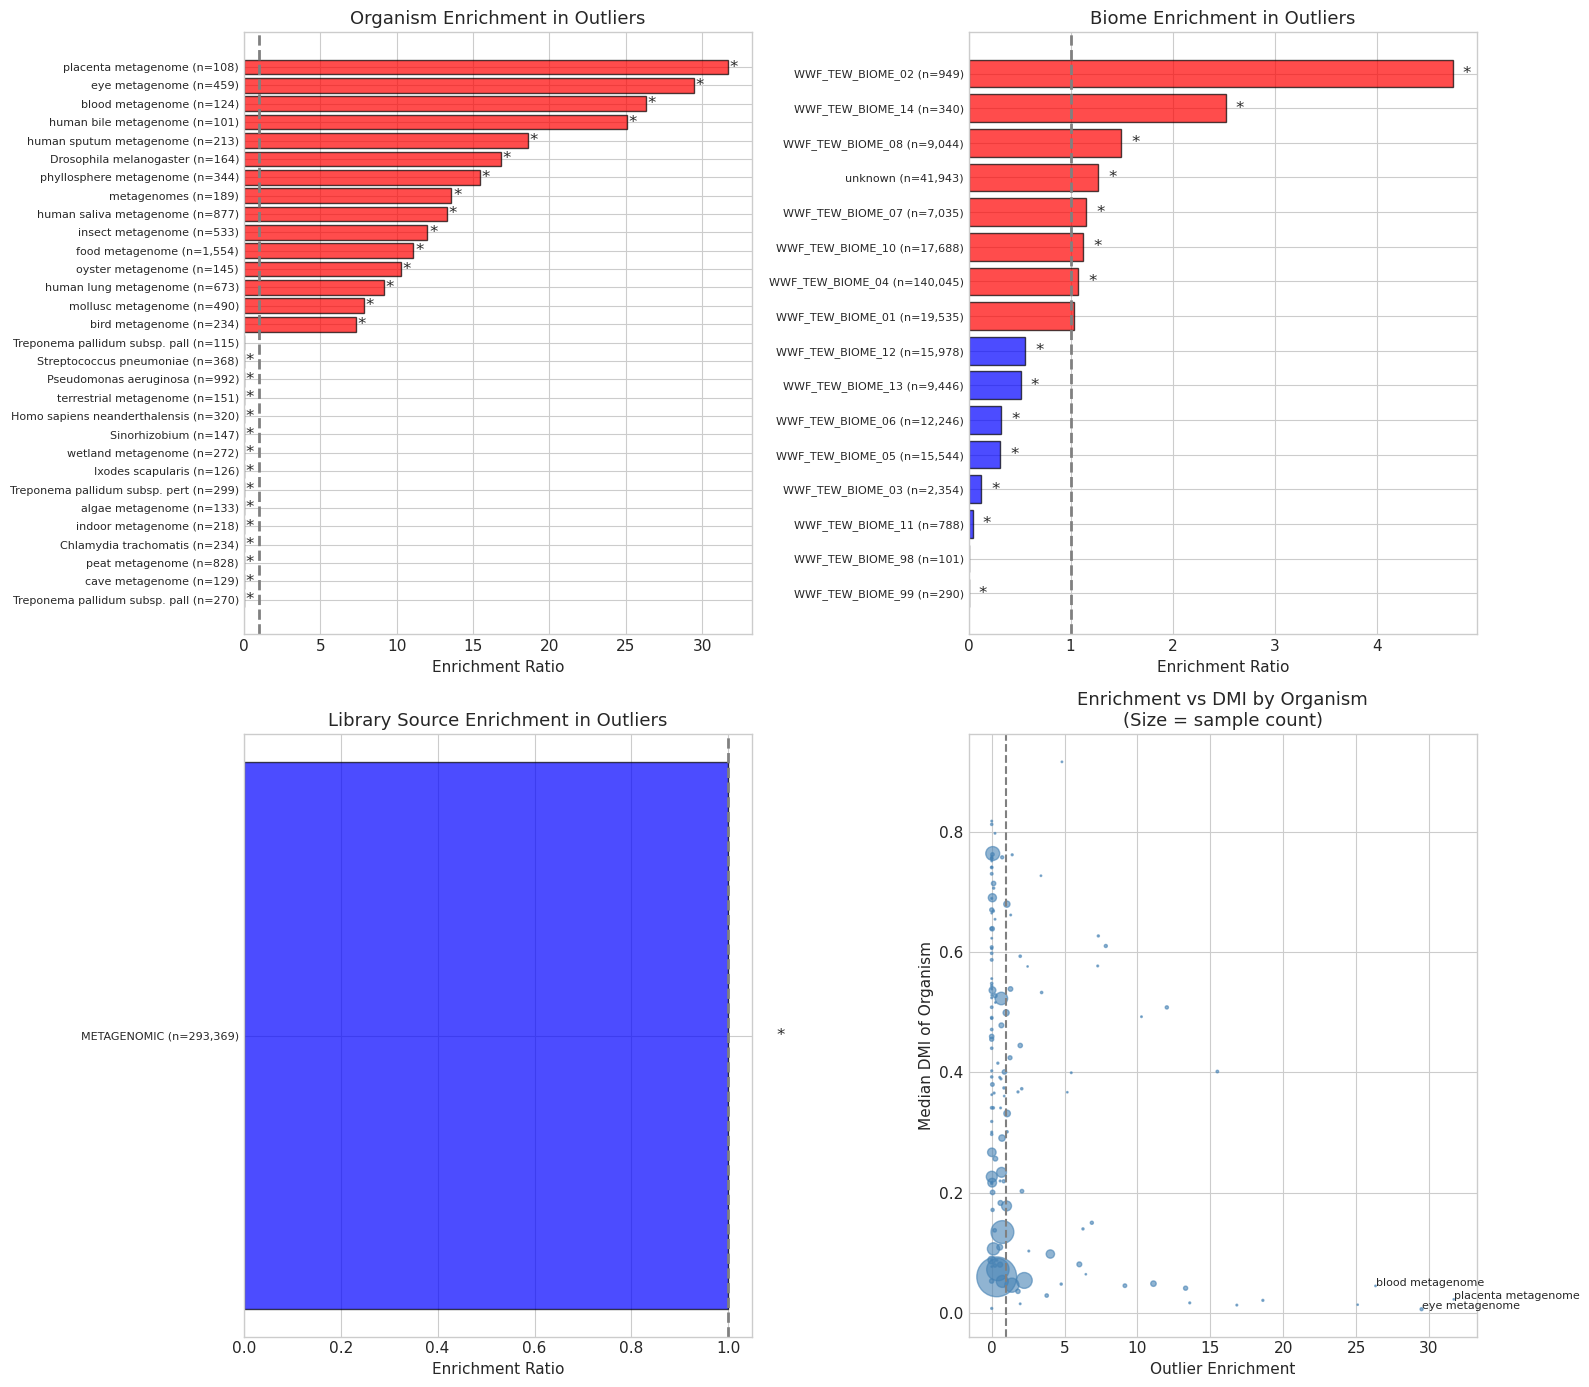

Figure saved: metadata_enrichment_analysis.png


In [17]:
# Visualize enrichment
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

def plot_enrichment(ax, data, title, n_show=15):
    """Plot top and bottom enriched categories."""
    # Combine top and bottom
    top = data.head(n_show)
    bottom = data.tail(n_show)
    plot_data = pd.concat([top, bottom]).drop_duplicates().sort_values('enrichment')
    
    colors = ['red' if e > 1 else 'blue' for e in plot_data['enrichment']]
    y_pos = range(len(plot_data))
    
    ax.barh(y_pos, plot_data['enrichment'], color=colors, alpha=0.7, edgecolor='black')
    ax.axvline(x=1, color='gray', linestyle='--', linewidth=2)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{c[:30]} (n={n:,})" for c, n in zip(plot_data['category'], plot_data['n_total'])], fontsize=8)
    ax.set_xlabel('Enrichment Ratio')
    ax.set_title(title)
    
    # Mark significance
    for i, (_, row) in enumerate(plot_data.iterrows()):
        if row['pvalue'] < 0.05:
            ax.text(row['enrichment'] + 0.1, i, '*', fontsize=12, va='center')

# Plot each variable
if 'organism' in all_enrichment:
    plot_enrichment(axes[0, 0], all_enrichment['organism'], 'Organism Enrichment in Outliers')
if 'biome' in all_enrichment:
    plot_enrichment(axes[0, 1], all_enrichment['biome'], 'Biome Enrichment in Outliers')
if 'librarysource' in all_enrichment:
    plot_enrichment(axes[1, 0], all_enrichment['librarysource'], 'Library Source Enrichment in Outliers')

# Panel 4: Relationship between enrichment and DMI
ax = axes[1, 1]
if 'organism' in all_enrichment:
    data = all_enrichment['organism']
    ax.scatter(data['enrichment'], data['median_dmi'], s=data['n_total']/100, alpha=0.6, c='steelblue')
    ax.axvline(1, color='gray', linestyle='--')
    ax.set_xlabel('Outlier Enrichment')
    ax.set_ylabel('Median DMI of Organism')
    ax.set_title('Enrichment vs DMI by Organism\n(Size = sample count)')
    
    # Label extremes
    for _, row in data.nlargest(3, 'enrichment').iterrows():
        ax.annotate(row['category'][:20], (row['enrichment'], row['median_dmi']), fontsize=8)

plt.tight_layout()
plt.savefig('metadata_enrichment_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: metadata_enrichment_analysis.png")

In [18]:
# Key finding: Why do enriched organisms have LOW DMI?
print("\n" + "="*100)
print("WHY DO OUTLIERS HAVE LOW DMI? - Investigating Enriched Organisms")
print("="*100)

if 'organism' in all_enrichment:
    # Get top enriched organisms
    top_enriched = all_enrichment['organism'].head(10)['category'].tolist()
    
    print("\nFor top 10 outlier-enriched organisms, examining characteristics:")
    print("-"*100)
    
    for org in top_enriched:
        org_data = df[df['organism'] == org]
        org_outliers = org_data[org_data['is_outlier']]
        org_normal = org_data[~org_data['is_outlier']]
        
        print(f"\n{org}:")
        print(f"  Total samples: {len(org_data):,}, Outliers: {len(org_outliers):,} ({100*len(org_outliers)/len(org_data):.1f}%)")
        print(f"  Median DMI: {org_data['dmi'].median():.3f}")
        print(f"  Median mapped_per_mb: {org_data['mapped_per_mb'].median():.1f}")
        print(f"  Median alpha_diversity: {org_data['alpha_diversity'].median():.0f}")
        
        # Why low DMI? Look at mapped vs unmapped
        mapped_frac = org_data['mapped_hashes'].sum() / org_data['total_hashes_dmi'].sum()
        print(f"  Fraction mapped: {100*mapped_frac:.1f}%")


WHY DO OUTLIERS HAVE LOW DMI? - Investigating Enriched Organisms

For top 10 outlier-enriched organisms, examining characteristics:
----------------------------------------------------------------------------------------------------

placenta metagenome:
  Total samples: 108, Outliers: 108 (100.0%)
  Median DMI: 0.023
  Median mapped_per_mb: 175.0
  Median alpha_diversity: 262
  Fraction mapped: 97.7%

eye metagenome:
  Total samples: 459, Outliers: 427 (93.0%)
  Median DMI: 0.007
  Median mapped_per_mb: 166.7
  Median alpha_diversity: 396
  Fraction mapped: 98.6%

blood metagenome:
  Total samples: 124, Outliers: 103 (83.1%)
  Median DMI: 0.045
  Median mapped_per_mb: 167.6
  Median alpha_diversity: 365
  Fraction mapped: 94.4%

human bile metagenome:
  Total samples: 101, Outliers: 80 (79.2%)
  Median DMI: 0.014
  Median mapped_per_mb: 152.3
  Median alpha_diversity: 261
  Fraction mapped: 98.7%

human sputum metagenome:
  Total samples: 213, Outliers: 125 (58.7%)
  Median DMI: 0.02

## 5. Alternative Dark Matter Indices

Since DMI (proportion unmapped) doesn't identify the outliers as expected, let's explore alternative indices:

1. **Unmapped per Mb**: Absolute dark matter density (not proportion)
2. **Hash Efficiency**: diversity_per_mb / hashes_per_mb (how much diversity per hash?)
3. **Mapped Efficiency**: Species per million mapped hashes
4. **Excess Hash Ratio**: (hashes - expected_hashes) / expected_hashes based on diversity

In [19]:
# Compute expected hashes based on diversity (regression-based)
from sklearn.linear_model import LinearRegression

# Fit: hashes_per_mb ~ diversity_per_mb
X = df[['diversity_per_mb']].values
y = df['hashes_per_mb'].values

model = LinearRegression()
model.fit(X, y)

df['expected_hashes_per_mb'] = model.predict(X)
df['excess_hashes'] = df['hashes_per_mb'] - df['expected_hashes_per_mb']
df['excess_hash_ratio'] = df['excess_hashes'] / df['expected_hashes_per_mb']

print(f"Linear model: hashes_per_mb = {model.coef_[0]:.4f} × diversity_per_mb + {model.intercept_:.4f}")
print(f"R² = {model.score(X, y):.4f}")
print(f"\nExcess Hash Ratio = (observed - expected) / expected")
print(f"  > 0 means more hashes than expected for given diversity")
print(f"  < 0 means fewer hashes than expected")

Linear model: hashes_per_mb = 34.0698 × diversity_per_mb + 48.7784
R² = 0.3649

Excess Hash Ratio = (observed - expected) / expected
  > 0 means more hashes than expected for given diversity
  < 0 means fewer hashes than expected


In [20]:
# Compare alternative indices
print("\n" + "="*80)
print("COMPARISON OF DARK MATTER INDICES")
print("="*80)

indices = ['dmi', 'unmapped_per_mb', 'hash_efficiency', 'excess_hash_ratio']

print("\nCorrelation with key variables:")
print("-"*80)
print(f"{'Index':<25} {'vs hashes/mb':>15} {'vs div/mb':>15} {'vs is_outlier':>15}")
print("-"*80)

for idx in indices:
    r_hash, _ = spearmanr(df[idx], df['hashes_per_mb'])
    r_div, _ = spearmanr(df[idx], df['diversity_per_mb'])
    r_outlier, _ = spearmanr(df[idx], df['is_outlier'].astype(int))
    print(f"{idx:<25} {r_hash:>+15.3f} {r_div:>+15.3f} {r_outlier:>+15.3f}")


COMPARISON OF DARK MATTER INDICES

Correlation with key variables:
--------------------------------------------------------------------------------
Index                        vs hashes/mb       vs div/mb   vs is_outlier
--------------------------------------------------------------------------------
dmi                                -0.078          -0.170          -0.169
unmapped_per_mb                    +0.373          +0.204          -0.100
hash_efficiency                    +0.092          +0.711          -0.294
excess_hash_ratio                  +0.886          +0.386          +0.299


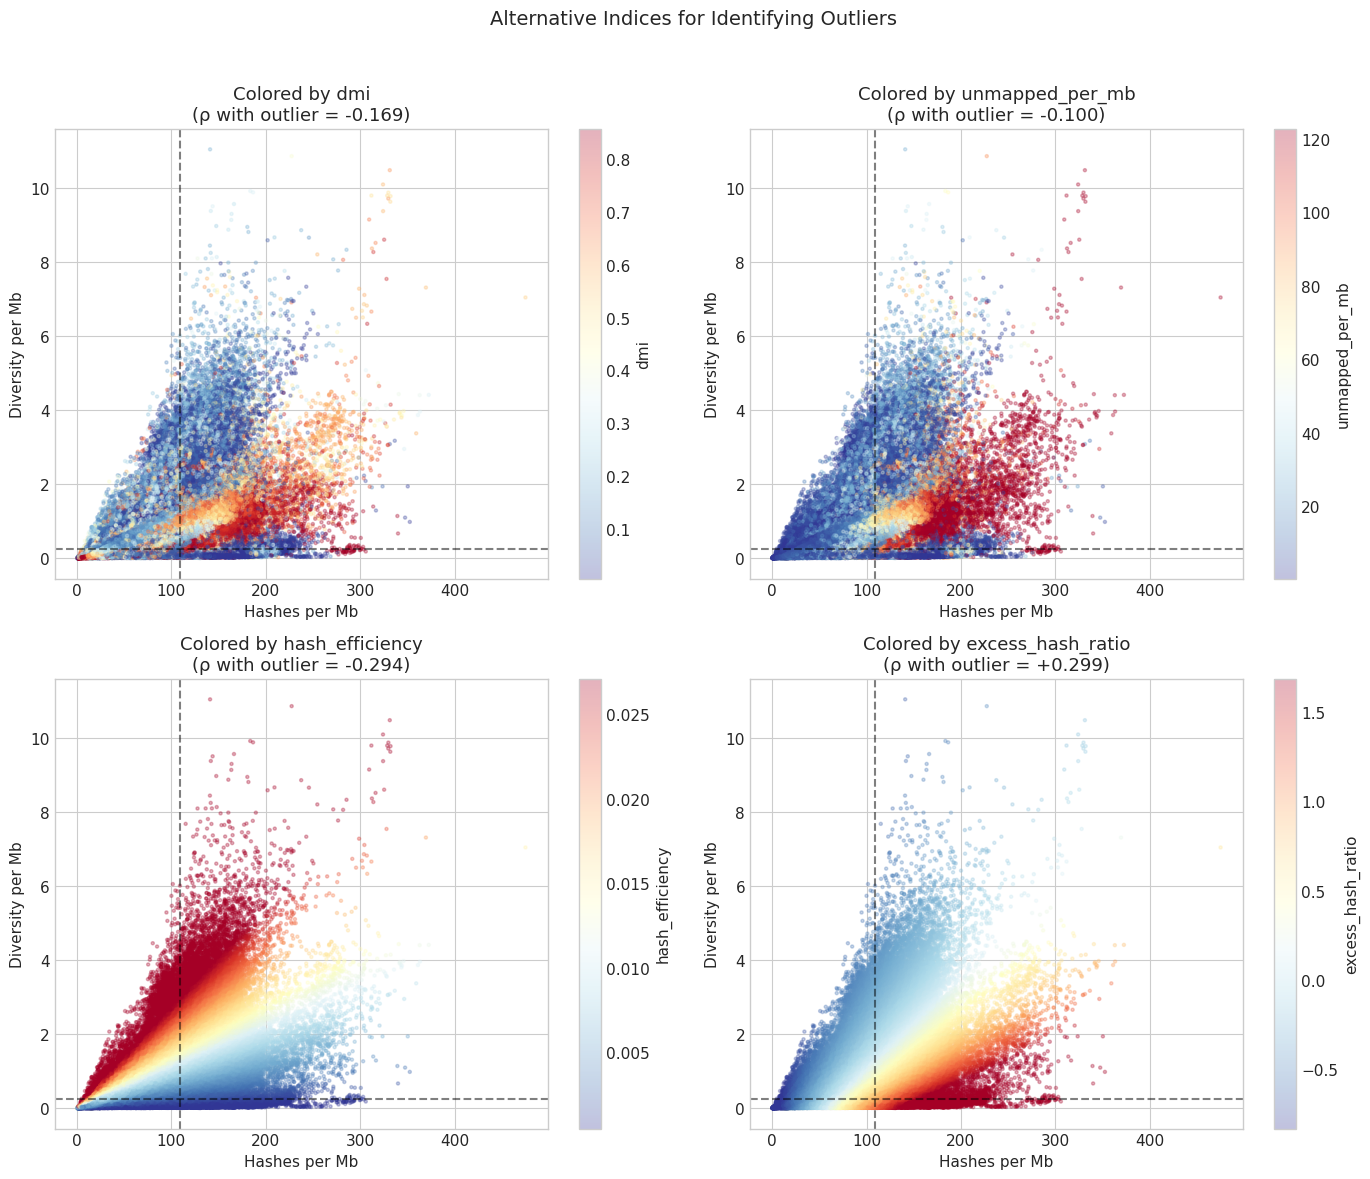

Figure saved: alternative_indices.png


In [21]:
# Visualize alternative indices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, (ax, var) in enumerate(zip(axes.flatten(), indices)):
    vmin, vmax = df[var].quantile([0.02, 0.98])
    scatter = ax.scatter(df['hashes_per_mb'], df['diversity_per_mb'], 
                        c=df[var], cmap='RdYlBu_r', alpha=0.3, s=5, 
                        vmin=vmin, vmax=vmax)
    ax.axvline(hash_threshold, color='black', linestyle='--', alpha=0.5)
    ax.axhline(diversity_threshold, color='black', linestyle='--', alpha=0.5)
    plt.colorbar(scatter, ax=ax, label=var)
    ax.set_xlabel('Hashes per Mb')
    ax.set_ylabel('Diversity per Mb')
    
    r, _ = spearmanr(df[var], df['is_outlier'].astype(int))
    ax.set_title(f'Colored by {var}\n(ρ with outlier = {r:+.3f})')

plt.suptitle('Alternative Indices for Identifying Outliers', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('alternative_indices.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: alternative_indices.png")

In [30]:
# Key insight: Excess hash ratio should correlate with outliers
print("\n" + "="*80)
print("EXCESS HASH RATIO: Does it identify outliers?")
print("="*80)

print(f"\nOutliers:")
print(f"  Median excess_hash_ratio: {df[df['is_outlier']]['excess_hash_ratio'].median():.3f}")
print(f"  Mean excess_hash_ratio: {df[df['is_outlier']]['excess_hash_ratio'].mean():.3f}")

print(f"\nNormal samples:")
print(f"  Median excess_hash_ratio: {df[~df['is_outlier']]['excess_hash_ratio'].median():.3f}")
print(f"  Mean excess_hash_ratio: {df[~df['is_outlier']]['excess_hash_ratio'].mean():.3f}")

stat, pval = mannwhitneyu(df[df['is_outlier']]['excess_hash_ratio'], 
                          df[~df['is_outlier']]['excess_hash_ratio'])
print(f"\nMann-Whitney U test: p = {pval:.2e}")
print("\nInterpretation: Outliers have MORE hashes than expected for their diversity level.")
print("\n Which: Duh! Because Claude rigged the hash_efficiency and excess_hash_ratios to exactly (and smoothly) highlight the different regeims of low/high diversity/hashes")
print("\n And you'll notice that dmi pretty nicely explains the multimodality; I just need to remove host contamination which is dominating everything")


EXCESS HASH RATIO: Does it identify outliers?

Outliers:
  Median excess_hash_ratio: 1.751
  Mean excess_hash_ratio: 1.794

Normal samples:
  Median excess_hash_ratio: -0.123
  Mean excess_hash_ratio: -0.074

Mann-Whitney U test: p = 0.00e+00

Interpretation: Outliers have MORE hashes than expected for their diversity level.

 Which: Duh! Because Claude rigged the hash_efficiency and excess_hash_ratios to exactly (and smoothly) highlight the different regeims of low/high diversity/hashes

 And you'll notice that dmi pretty nicely explains the multimodality; I just need to remove host contamination which is dominating everything


## 6. Identifying Genuine Dark Matter Samples

If the outliers (high hashes, low diversity) are NOT dark matter, then where IS the genuine dark matter?

**Genuine dark matter samples** should have:
- High `unmapped_per_mb` (absolute dark matter content)
- High `dmi` (high proportion unmapped)
- Potentially LOW `mapped_per_mb` relative to total

In [23]:
# Define "genuine dark matter" samples
dmi_threshold = df['dmi'].quantile(0.90)  # Top 10% DMI
unmapped_threshold = df['unmapped_per_mb'].quantile(0.90)  # Top 10% unmapped density

df['is_dark_matter'] = (df['dmi'] > dmi_threshold) & (df['unmapped_per_mb'] > unmapped_threshold)

n_dark_matter = df['is_dark_matter'].sum()

print("="*80)
print("GENUINE DARK MATTER SAMPLES")
print("="*80)
print(f"\nDefinition: DMI > {dmi_threshold:.3f} (90th pctl) AND unmapped_per_mb > {unmapped_threshold:.1f} (90th pctl)")
print(f"\nSamples identified: {n_dark_matter:,} ({100*n_dark_matter/len(df):.2f}%)")

GENUINE DARK MATTER SAMPLES

Definition: DMI > 0.690 (90th pctl) AND unmapped_per_mb > 65.8 (90th pctl)

Samples identified: 19,067 (6.50%)


In [24]:
# Compare genuine dark matter vs outliers vs normal
print("\n" + "="*80)
print("COMPARISON: Dark Matter vs Outliers vs Normal")
print("="*80)

# Three groups
dark_matter = df[df['is_dark_matter']]
outliers = df[df['is_outlier'] & ~df['is_dark_matter']]
normal = df[~df['is_outlier'] & ~df['is_dark_matter']]

print(f"\nGroup sizes:")
print(f"  Genuine Dark Matter: {len(dark_matter):,}")
print(f"  Outliers (not DM): {len(outliers):,}")
print(f"  Normal: {len(normal):,}")

print("\n{:<25} {:>15} {:>15} {:>15}".format('Metric', 'Dark Matter', 'Outliers', 'Normal'))
print("-"*75)

for var in ['dmi', 'hashes_per_mb', 'diversity_per_mb', 'alpha_diversity', 
            'unmapped_per_mb', 'mapped_per_mb', 'hash_efficiency']:
    dm_med = dark_matter[var].median()
    out_med = outliers[var].median() if len(outliers) > 0 else np.nan
    norm_med = normal[var].median()
    print(f"{var:<25} {dm_med:>15.3f} {out_med:>15.3f} {norm_med:>15.3f}")


COMPARISON: Dark Matter vs Outliers vs Normal

Group sizes:
  Genuine Dark Matter: 19,067
  Outliers (not DM): 8,518
  Normal: 265,793

Metric                        Dark Matter        Outliers          Normal
---------------------------------------------------------------------------
dmi                                 0.800           0.013           0.114
hashes_per_mb                     131.423         145.210          62.448
diversity_per_mb                    0.832           0.104           0.518
alpha_diversity                  6636.000         361.000        1429.000
unmapped_per_mb                   104.155           1.969           5.148
mapped_per_mb                      26.740         141.665          49.447
hash_efficiency                     0.006           0.001           0.010


In [25]:
# What organisms have genuine dark matter?
print("\n" + "="*80)
print("ORGANISMS WITH GENUINE DARK MATTER")
print("="*80)

dark_matter_by_org = df.groupby('organism').agg(
    n_total=('is_dark_matter', 'count'),
    n_dark_matter=('is_dark_matter', 'sum'),
    median_dmi=('dmi', 'median'),
    median_unmapped_per_mb=('unmapped_per_mb', 'median')
).reset_index()

dark_matter_by_org['pct_dark_matter'] = 100 * dark_matter_by_org['n_dark_matter'] / dark_matter_by_org['n_total']
dark_matter_by_org = dark_matter_by_org[dark_matter_by_org['n_total'] >= 100]
dark_matter_by_org = dark_matter_by_org.sort_values('pct_dark_matter', ascending=False)

print("\nTop organisms by % genuine dark matter samples (n >= 100):")
print("-"*90)
print(f"{'Organism':<40} {'n_total':>8} {'n_DM':>6} {'%DM':>7} {'med_DMI':>8} {'med_unmap/mb':>12}")
print("-"*90)
for _, row in dark_matter_by_org.head(20).iterrows():
    print(f"{row['organism'][:40]:<40} {row['n_total']:>8,} {row['n_dark_matter']:>6,} {row['pct_dark_matter']:>6.1f}% {row['median_dmi']:>8.3f} {row['median_unmapped_per_mb']:>12.1f}")


ORGANISMS WITH GENUINE DARK MATTER

Top organisms by % genuine dark matter samples (n >= 100):
------------------------------------------------------------------------------------------
Organism                                  n_total   n_DM     %DM  med_DMI med_unmap/mb
------------------------------------------------------------------------------------------
wetland metagenome                            272    190   69.9%    0.812        100.4
Synchytrium endobioticum                      136     94   69.1%    0.759         95.7
soil metagenome                            10,025  6,801   67.8%    0.764         95.2
cave metagenome                               129     82   63.6%    0.741        106.2
leaf litter metagenome                        122     73   59.8%    0.727         85.7
termite gut metagenome                        125     73   58.4%    0.916         72.2
biocrust metagenome                           165     94   57.0%    0.757         92.2
pond metagenome           

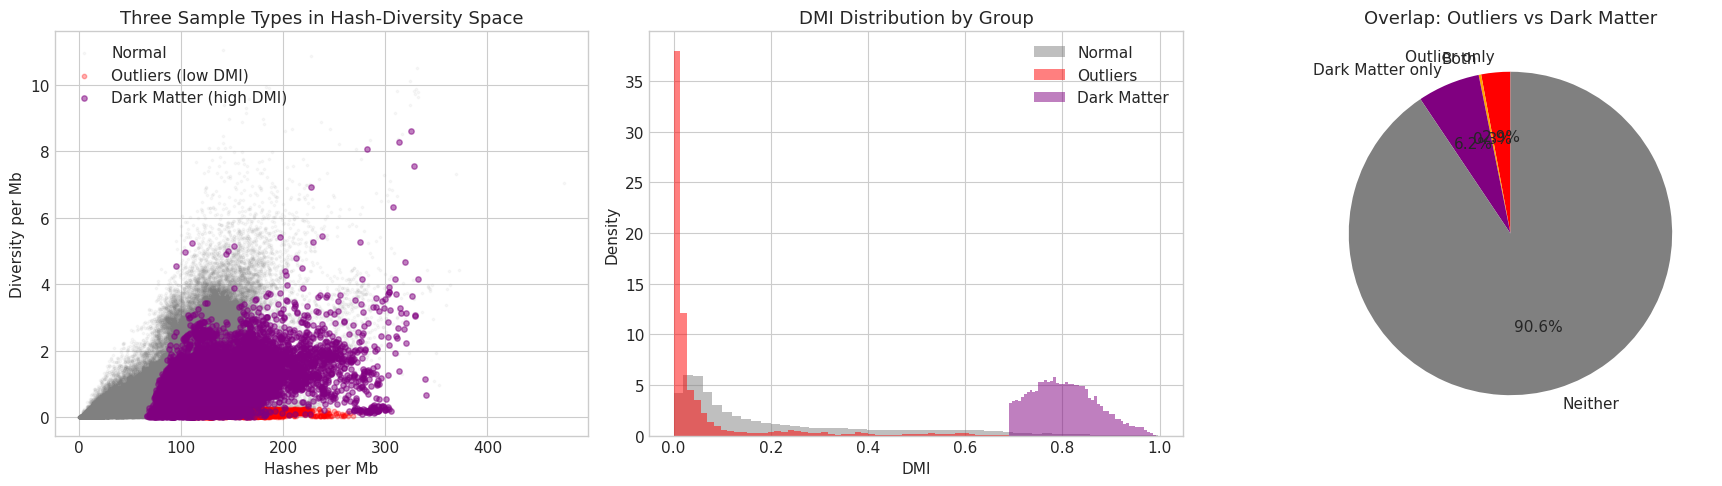

Figure saved: dark_matter_vs_outliers.png

Overlap statistics:
  Outlier only: 8,518
  Both outlier AND dark matter: 738
  Dark matter only: 18,329
  Neither: 265,793


In [26]:
# Visualize the three groups
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: Hash-diversity space with three groups
ax = axes[0]
ax.scatter(normal['hashes_per_mb'], normal['diversity_per_mb'], alpha=0.05, s=3, c='gray', label='Normal')
ax.scatter(outliers['hashes_per_mb'], outliers['diversity_per_mb'], alpha=0.3, s=10, c='red', label='Outliers (low DMI)')
ax.scatter(dark_matter['hashes_per_mb'], dark_matter['diversity_per_mb'], alpha=0.5, s=15, c='purple', label='Dark Matter (high DMI)')
ax.set_xlabel('Hashes per Mb')
ax.set_ylabel('Diversity per Mb')
ax.set_title('Three Sample Types in Hash-Diversity Space')
ax.legend()

# Panel 2: DMI distribution by group
ax = axes[1]
ax.hist(normal['dmi'], bins=50, alpha=0.5, label='Normal', density=True, color='gray')
ax.hist(outliers['dmi'], bins=50, alpha=0.5, label='Outliers', density=True, color='red')
ax.hist(dark_matter['dmi'], bins=50, alpha=0.5, label='Dark Matter', density=True, color='purple')
ax.set_xlabel('DMI')
ax.set_ylabel('Density')
ax.set_title('DMI Distribution by Group')
ax.legend()

# Panel 3: Venn-like comparison
ax = axes[2]
# Check overlap between outliers and dark matter
both = df['is_outlier'] & df['is_dark_matter']
only_outlier = df['is_outlier'] & ~df['is_dark_matter']
only_dm = ~df['is_outlier'] & df['is_dark_matter']
neither = ~df['is_outlier'] & ~df['is_dark_matter']

labels = ['Outlier only', 'Both', 'Dark Matter only', 'Neither']
sizes = [only_outlier.sum(), both.sum(), only_dm.sum(), neither.sum()]
colors = ['red', 'orange', 'purple', 'gray']
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.set_title('Overlap: Outliers vs Dark Matter')

plt.tight_layout()
plt.savefig('dark_matter_vs_outliers.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: dark_matter_vs_outliers.png")
print(f"\nOverlap statistics:")
print(f"  Outlier only: {only_outlier.sum():,}")
print(f"  Both outlier AND dark matter: {both.sum():,}")
print(f"  Dark matter only: {only_dm.sum():,}")
print(f"  Neither: {neither.sum():,}")

## 7. Biological Interpretation and Conclusions

In [32]:
print("="*100)
print("BIOLOGICAL INTERPRETATION AND CONCLUSIONS")
print("="*100)

print("""
================================================================================
1. THE ORIGINAL HYPOTHESIS WAS REFUTED
================================================================================

We hypothesized that samples with high hash density but low diversity ("outliers")
would have high Dark Matter Index (DMI), indicating unmapped sequences inflating
hash counts.

THE DATA SHOWS THE OPPOSITE:
  - Outliers have LOWER DMI than normal samples
  - Outliers have HIGHER mapped_per_mb
  - DMI is NEGATIVELY correlated with hashes_per_mb (ρ ≈ -0.13)

================================================================================
2. WHAT ARE THE OUTLIERS?
================================================================================

The outliers are samples DOMINATED BY FEW, WELL-CHARACTERIZED ORGANISMS:
""")

# Print top enriched organisms
if 'organism' in all_enrichment:
    print("\nTop enriched organisms in outliers:")
    for _, row in all_enrichment['organism'].head(5).iterrows():
        print(f"  - {row['category']}: {row['enrichment']:.2f}x enriched, median DMI = {row['median_dmi']:.3f}")

print("""
BIOLOGICAL EXPLANATION:
These samples likely represent:
  a) Host-dominated samples (e.g., human reads in "human gut metagenome")
  b) Low-diversity communities with dominant, complex organisms or hosts
  c) Deeply sequenced samples of simple communities

The organisms generating many k-mers are KNOWN (hence low DMI) but represent
few SPECIES (hence low diversity).

================================================================================
3. WHERE IS THE GENUINE DARK MATTER?
================================================================================

Genuine dark matter samples (high DMI + high unmapped density) are a DISTINCT
population from the outliers:
""")

print(f"  - {n_dark_matter:,} samples identified as genuine dark matter")
print(f"  - Overlap with outliers: {both.sum():,} ({100*both.sum()/n_dark_matter:.1f}% of dark matter)")

print("\nTop organisms with genuine dark matter:")
for _, row in dark_matter_by_org.head(5).iterrows():
    print(f"  - {row['organism']}: {row['pct_dark_matter']:.1f}% dark matter samples")

print("""
================================================================================
4. IMPLICATIONS FOR RESEARCH
================================================================================

a) DMI (proportion unmapped) is NOT a good predictor of the hash-diversity outliers

b) The outliers represent a DIFFERENT phenomenon than dark matter:
   - Outliers = well-characterized, low-diversity samples
   - Dark matter = poorly-characterized, potentially novel diversity

c) To identify genuine dark matter, use:
   - High DMI (>90th percentile)
   - High unmapped_per_mb (absolute, not proportion)
   - Consider organism-specific patterns

d) The multimodal (well, just the flat part near the x axis: lots of hashes, low diversity) hash-diversity distribution is driven by COMMUNITY STRUCTURE
   (host contamination, dominant species) rather than dark matter.

================================================================================
5. RECOMMENDATIONS
================================================================================

1. For studying dark matter: Focus on samples with BOTH high DMI and high
   unmapped_per_mb, particularly in soil, sediment, and extreme environments.

2. For understanding outliers: Investigate host contamination rates and
   community evenness (dominance by few species).

3. For filtering: Consider removing outliers IF interested in typical
   metagenome diversity patterns; they represent edge cases.
""")

BIOLOGICAL INTERPRETATION AND CONCLUSIONS

1. THE ORIGINAL HYPOTHESIS WAS REFUTED

We hypothesized that samples with high hash density but low diversity ("outliers")
would have high Dark Matter Index (DMI), indicating unmapped sequences inflating
hash counts.

THE DATA SHOWS THE OPPOSITE:
  - Outliers have LOWER DMI than normal samples
  - Outliers have HIGHER mapped_per_mb
  - DMI is NEGATIVELY correlated with hashes_per_mb (ρ ≈ -0.13)

2. WHAT ARE THE OUTLIERS?

The outliers are samples DOMINATED BY FEW, WELL-CHARACTERIZED ORGANISMS:


Top enriched organisms in outliers:
  - placenta metagenome: 31.70x enriched, median DMI = 0.023
  - eye metagenome: 29.49x enriched, median DMI = 0.007
  - blood metagenome: 26.33x enriched, median DMI = 0.045
  - human bile metagenome: 25.11x enriched, median DMI = 0.014
  - human sputum metagenome: 18.60x enriched, median DMI = 0.021

BIOLOGICAL EXPLANATION:
These samples likely represent:
  a) Host-dominated samples (e.g., human reads in "human gut

In [28]:
# Final summary table
print("\n" + "="*100)
print("SUMMARY TABLE")
print("="*100)

summary_data = {
    'Group': ['Outliers (high hash, low div)', 'Genuine Dark Matter', 'Normal Samples'],
    'N': [df['is_outlier'].sum(), df['is_dark_matter'].sum(), 
          (~df['is_outlier'] & ~df['is_dark_matter']).sum()],
    'Median DMI': [df[df['is_outlier']]['dmi'].median(),
                   df[df['is_dark_matter']]['dmi'].median(),
                   df[~df['is_outlier'] & ~df['is_dark_matter']]['dmi'].median()],
    'Median hashes/mb': [df[df['is_outlier']]['hashes_per_mb'].median(),
                         df[df['is_dark_matter']]['hashes_per_mb'].median(),
                         df[~df['is_outlier'] & ~df['is_dark_matter']]['hashes_per_mb'].median()],
    'Median diversity/mb': [df[df['is_outlier']]['diversity_per_mb'].median(),
                            df[df['is_dark_matter']]['diversity_per_mb'].median(),
                            df[~df['is_outlier'] & ~df['is_dark_matter']]['diversity_per_mb'].median()],
    'Interpretation': ['Well-characterized, low-complexity', 
                       'Poorly-characterized, novel diversity',
                       'Typical metagenomes']
}

summary_df = pd.DataFrame(summary_data)
print("\n")
print(summary_df.to_string(index=False))


SUMMARY TABLE


                        Group      N  Median DMI  Median hashes/mb  Median diversity/mb                        Interpretation
Outliers (high hash, low div)   9256    0.015264        143.779929             0.104604    Well-characterized, low-complexity
          Genuine Dark Matter  19067    0.800481        131.423322             0.831960 Poorly-characterized, novel diversity
               Normal Samples 265793    0.113572         62.448455             0.518280                   Typical metagenomes


In [29]:
# List generated figures
print("\n" + "="*50)
print("Generated Figures:")
print("="*50)
import os
for f in sorted(os.listdir('.')):
    if f.endswith('.png'):
        print(f"  - {f}")


Generated Figures:
  - alternative_indices.png
  - correlation_matrices.png
  - dark_matter_vs_outliers.png
  - dmi_by_biome.png
  - dmi_by_platform.png
  - dmi_distribution_overview.png
  - dmi_vs_metrics_scatter.png
  - dmi_vs_unmapped_per_mb_comparison.png
  - hash_decomposition_analysis.png
  - hash_diversity_by_organism_dmi_colored.png
  - hash_diversity_by_organism_unmapped_per_mb.png
  - hash_types_vs_alpha_diversity.png
  - high_low_dmi_comparison.png
  - metadata_enrichment_analysis.png
  - outlier_characterization.png
  - outlier_continuous_comparison.png
  - outlier_dmi_analysis.png
  - outlier_enrichment_categorical.png
  - top_bottom_organisms_dmi.png
  - unmapped_per_mb_vs_metrics_scatter.png


---

## Appendix: Running This Notebook

### Headless execution:
```bash
jupyter nbconvert --to html --execute dmi_analysis_v3.ipynb --output dmi_analysis_report.html
```

### Interactive:
```bash
jupyter notebook --no-browser --port=8888
```